<a href="https://colab.research.google.com/github/st43r/GarbageCounter/blob/main/GarbageCounterYOLOv8-L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт бибилиотеки для модели нейросети YOLOv8-L

In [ ]:
%pip install ultralytics

# Основная функция-трекер-счетчик, которая следит за уникальными объектами на картинке, подсчитывает их, соотвественно классифицирую и обнаруживая.

In [109]:
import cv2
from collections import defaultdict
from ultralytics import YOLO
from pathlib import Path

def process_video(video_path: str, csv_path:str, model_path:str) -> dict:
    OUT_PATH = Path("/content/drive/MyDrive/out_imgs/")

    model = YOLO(model_path)

    cap = cv2.VideoCapture(video_path)

    frame_i = 0

    headers = "frame_id;wood;glass;plastic;metal\n"
    strings = ""

    all_count = defaultdict(set)

    while cap.isOpened():

        success, frame = cap.read()

        if success:

            results = model.track(frame, persist=True, verbose=False)

            # annotated_frame = results[0].plot()

            classes_count = defaultdict(set)

            for cls, track_id, xyxyn in zip(results[0].boxes.cls, results[0].boxes.id, results[0].boxes.xyxyn):
                classes_count[int(cls.data)].add(int(track_id.data))

                if xyxyn[0] > 0.1 and xyxyn[2] < 0.8:
                    all_count[int(cls.data)].add(int(track_id.data))


            # cv2.imwrite(str(OUT_PATH / f"{frame_i:04d}.jpg"), annotated_frame)
            # Если понадобится сделать поток из размеченных картинок


            strings += ";".join([
                    f"f{frame_i}",
                    f"{len(classes_count[0])}",
                    f"{len(classes_count[1])}",
                    f"{len(classes_count[2])}",
                    f"{len(classes_count[3])}",
                ]) + '\n'

            frame_i += 1

        else:
            break


    cap.release()

    strings += ";".join([
                    f"f_all",
                    f"{len(all_count[0])}",
                    f"{len(all_count[1])}",
                    f"{len(all_count[2])}",
                    f"{len(all_count[3])}",
                ])

    with open(csv_path, 'w') as f:
        f.write(headers)
        f.write(strings)

    return all_count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Запуск скрипта для получения файла для отправки решения.

In [114]:
res = process_video("/content/drive/MyDrive/test/frames_rgb/%04d.png", "/content/drive/MyDrive/result_final.csv", "/content/drive/MyDrive/best.pt")

# Кол-во объектов по классам:

In [115]:
for key in range(4):
        print(len(res[key]))

50
48
90
44


# Скрипт для создания текстового файла с количеством объектов.

In [ ]:
def count_to_txt(data:dict, file_path:str):
    values = ""

    for key in range(4):
        values+=str(len(data[key]))+"\n"

    file_path += "output.txt"

    with open(file_path, 'w') as file:
        file.write(values.strip())

In [ ]:
count_to_txt(res,"/content/drive/MyDrive/test/")

67
59
57
61

# Импорт датасета

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="") # В публичном доступе нельзя светить API ключами, поэтому оставлю ссылку на датасет: https://universe.roboflow.com/garbagecounter/testcounter/dataset/4
project = rf.workspace("garbagecounter").project("testcounter")
dataset = project.version(6).download("yolov8")

In [ ]:
!pip install ultralytics

from ultralytics import YOLO

from IPython.display import display, Image

# Обучение модели

In [101]:
!yolo task=detect mode=train model=/content/runs/detect/train10/weights/best.pt data={dataset.location}/data.yaml epochs=1 imgsz=640 plots=True

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train10/weights/best.pt, data=/content/TestCounter-6/data.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tr

In [102]:
from IPython.display import Image, display

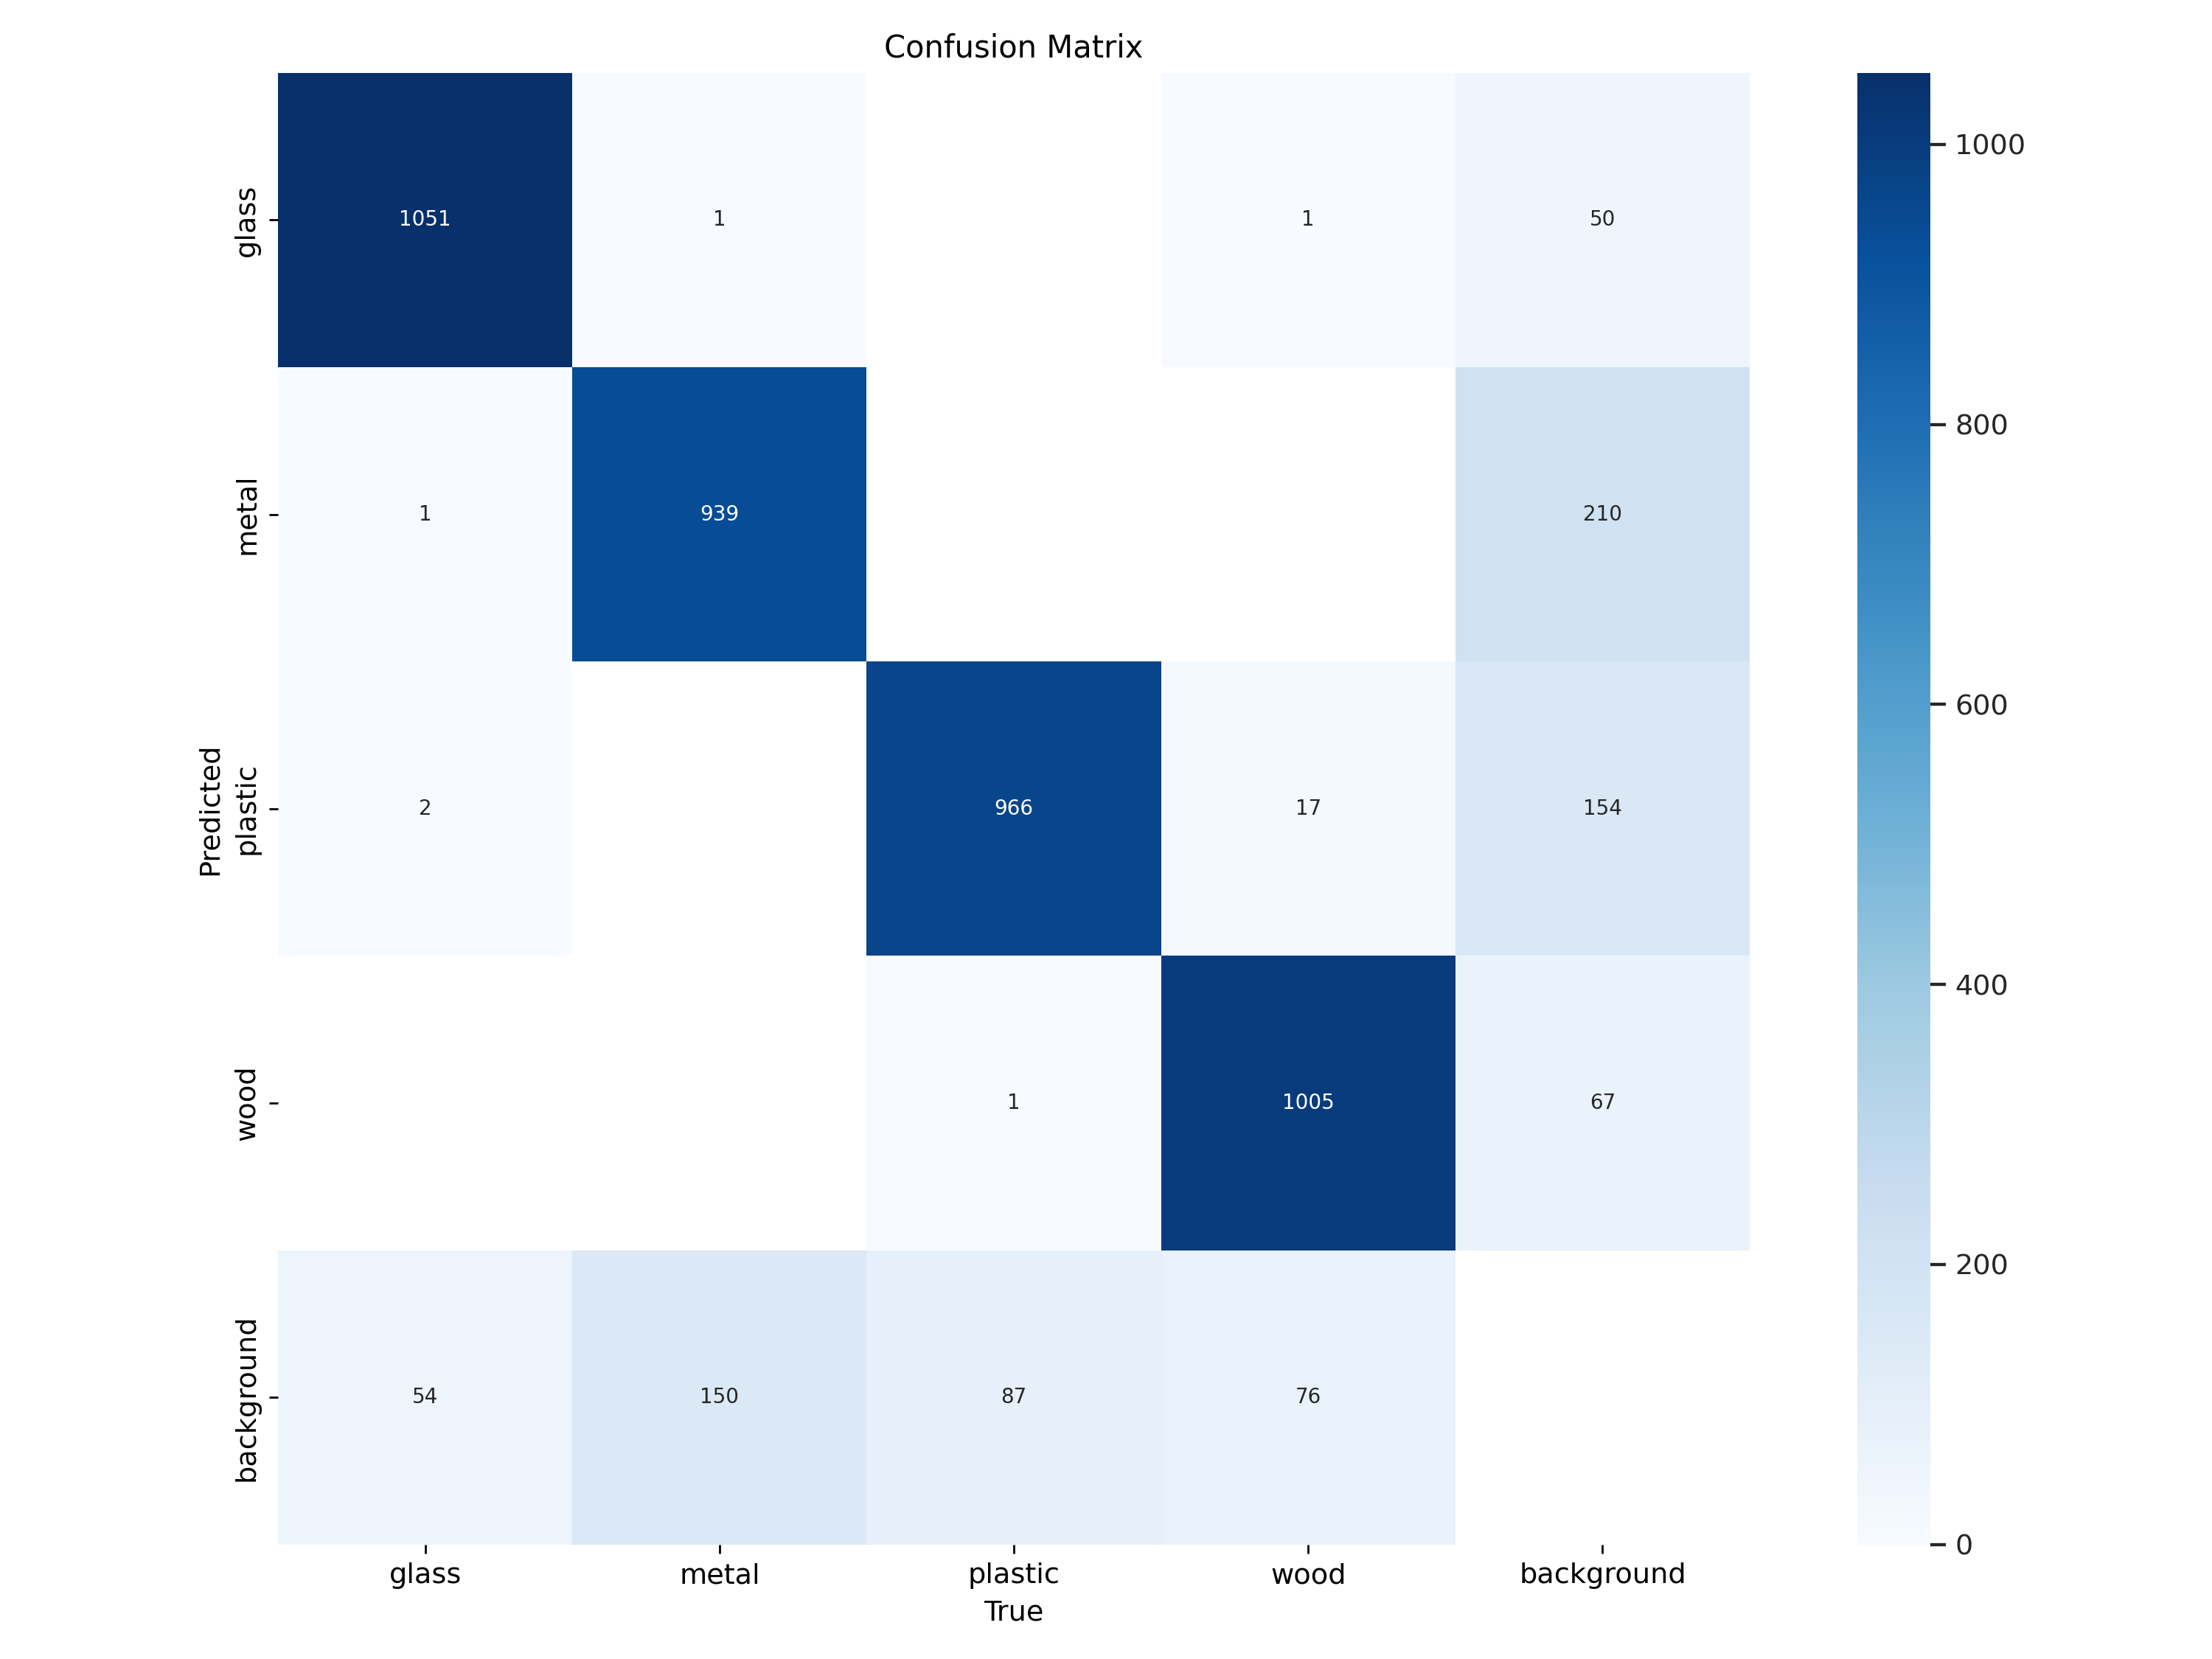

In [105]:
Image(filename=f'/content/runs/detect/train11/confusion_matrix.png', width=600)

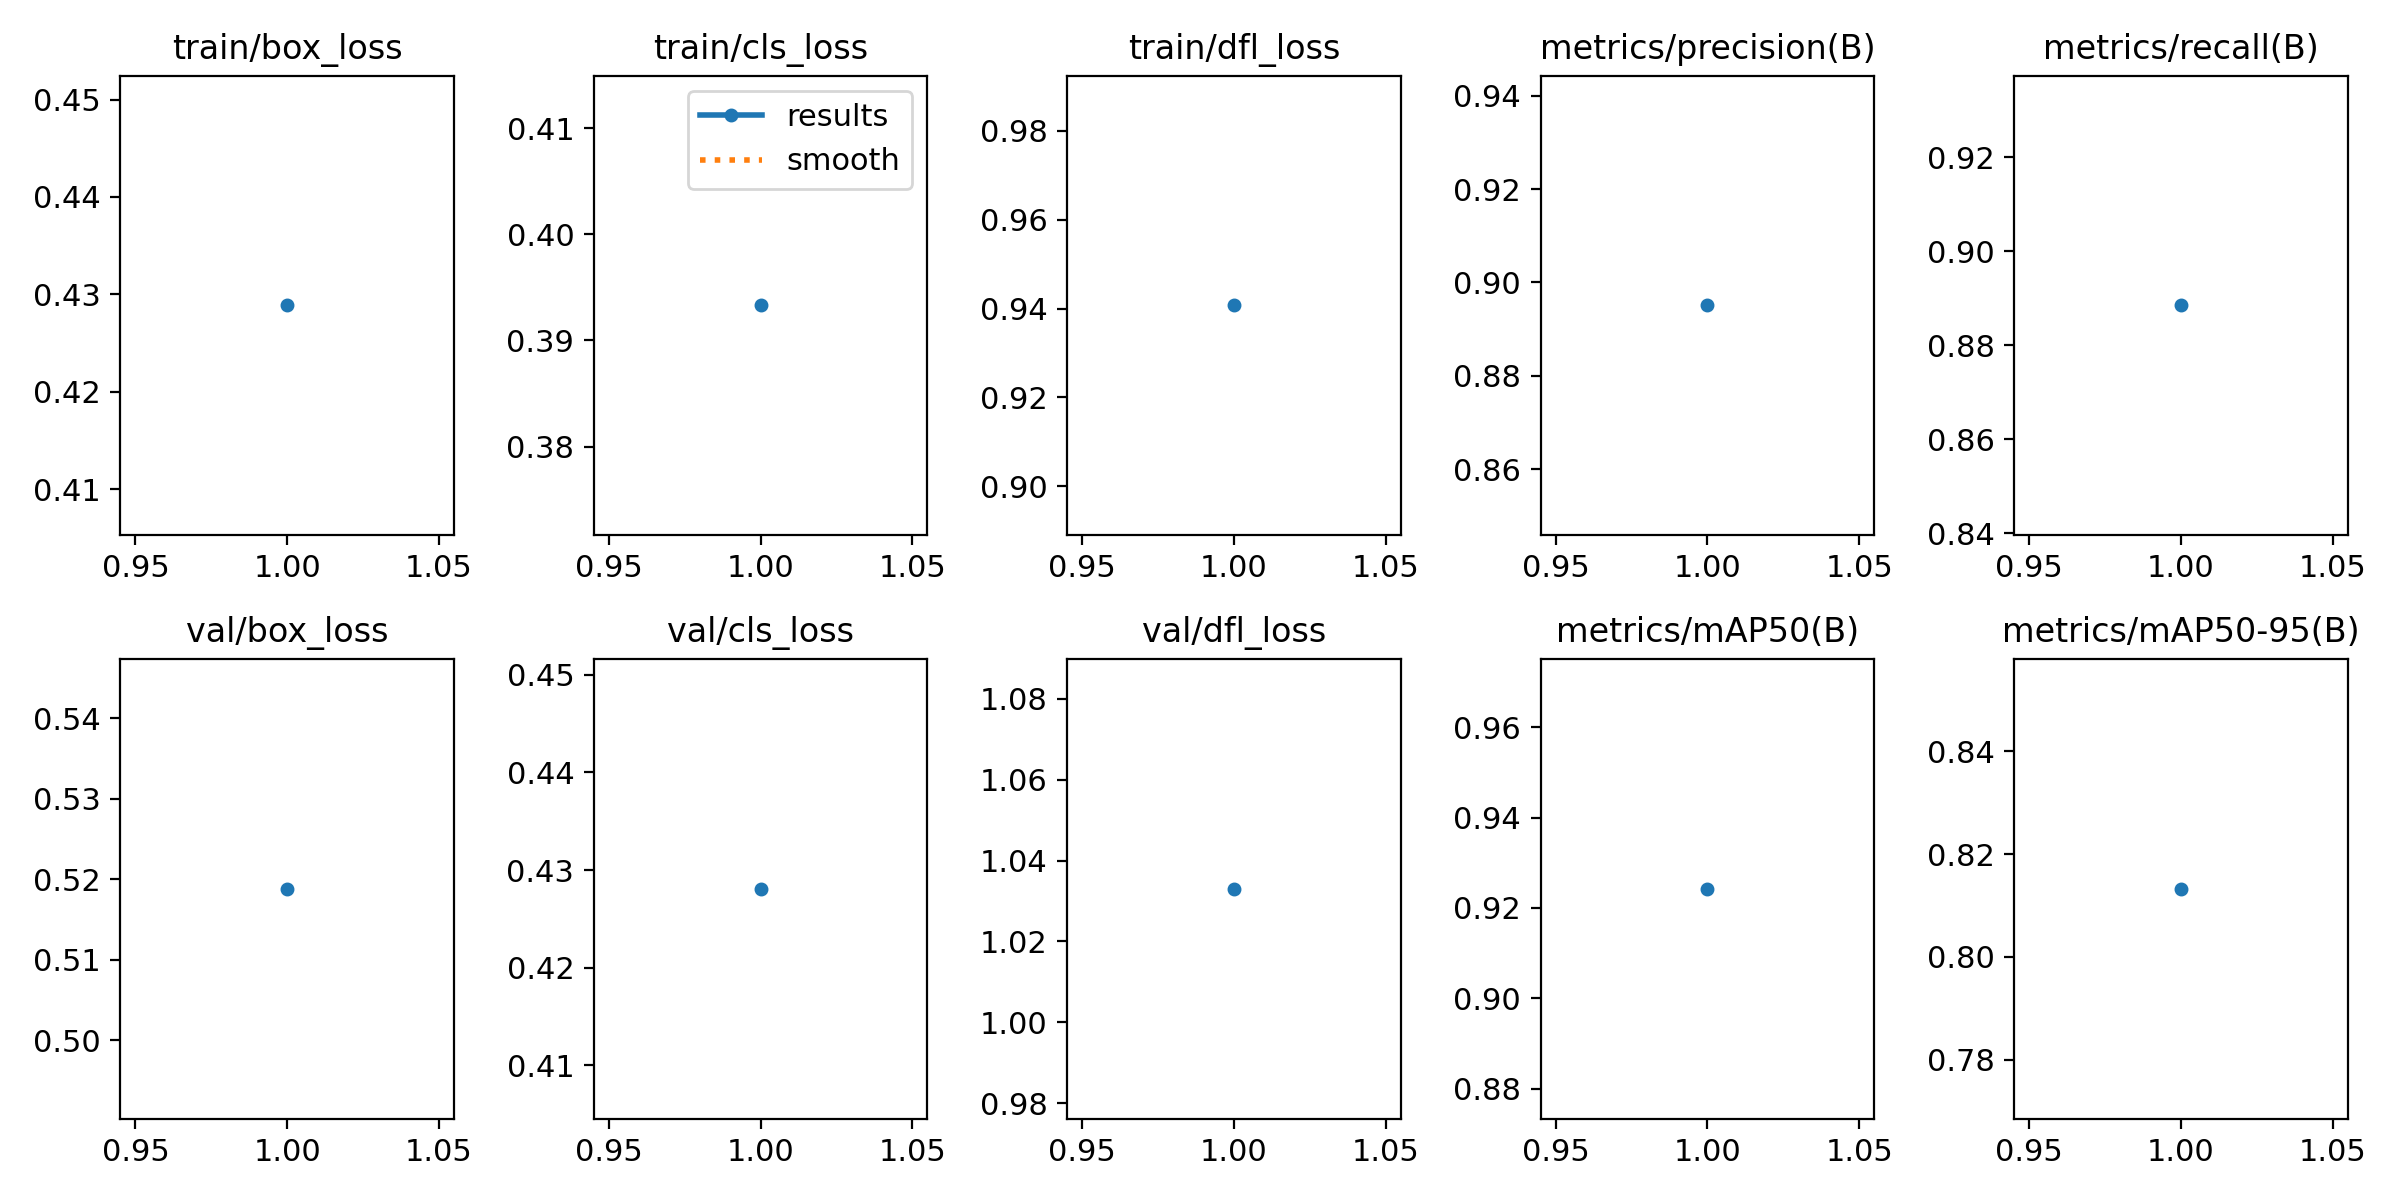

In [107]:
Image(filename=f'/content/runs/detect/train11/results.png', width=600)

In [108]:
!yolo task=detect mode=val model=/content/runs/detect/train10/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43609692 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /content/TestCounter-6/valid/labels.cache... 245 images, 14 backgrounds, 0 corrupt: 100% 245/245 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 16/16 [00:23<00:00,  1.48s/it]
                   all        245       4351      0.925      0.878      0.929       0.81
                 glass        245       1108      0.958      0.914      0.961      0.842
                 metal        245       1090      0.877      0.821      0.873      0.694
               plastic        245       1054      0.933      0.862      0.926      0.817
                  wood        245       1099       0.93      0.915      0.955      0.886
Speed: 1.8ms preprocess, 36.7ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at